<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow the link :
</p>

https://github.com/SMTorg/SMT/blob/master/README.md


<p class="alert alert-success" style="padding:1em">
The doc is available here:
</p>

https://smt.readthedocs.io/en/latest/

<div class="jumbotron text-left"><b>
This tutorial describes how to use the SMT toolbox with multifidelity data, using a co-kriging approach, called `MFCK`.

This approach is able to deal with:

*   nested  DOE
*   non nested DOE


</b></div>

Mauricio Castano Aguirre, October 2024. based on `smt 2.7.0`

# Installing SMT

In [1]:
#!pip install smt
!pip install git+https://github.com/SMTorg/smt.git@refs/pull/657/head

  Cloning https://github.com/SMTorg/smt.git (to revision refs/pull/657/head) to /tmp/pip-req-build-ks_mbj06
  Running command git clone --filter=blob:none --quiet https://github.com/SMTorg/smt.git /tmp/pip-req-build-ks_mbj06
  Running command git fetch -q https://github.com/SMTorg/smt.git refs/pull/657/head
  Running command git checkout -q 8bbbcb941fe9ffa9bf1bacd00fa8107dfee638a1
  Resolved https://github.com/SMTorg/smt.git to commit 8bbbcb941fe9ffa9bf1bacd00fa8107dfee638a1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 6.3 MB/s eta 0:00:00
  Created wheel for smt: filename=smt-2.7.0-cp310-cp310-linux_x86_64.whl size=685324 sha256=22f6df33e673033effcd430ee6efed548fd518f6e52eeb0447b349a723fe789a
  Stored in directory: /tmp/pip-ephem-wheel-cache-j5g_tfdw/wheels/d5

## Imports

In [3]:
from smt.applications import MFCK
from smt.applications import MFK
from smt.applications.mfk import NestedLHS
from smt.sampling_methods import LHS
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## 1- Build the multi-fidelity setup

For this tutorial we'll use de Forrester functions, well known functions in the multi-fidelity context, the base function is defined by:
$$
f(x)=(6x-2)^2\sin(12x-4)
$$

The function can be defined on any input domain but in this case will be evaluated on $x\in[0.0,1.0]$

The Forrester function is a relatively simple mathematical function used to test the performance of surrogate models. It is nonlinear, unimodal, and smooth, making it ideal for testing how well surrogate models or algorithms can approximate or optimize a function based on limited high-fidelity data.

In this context we define 3 different fidelity levels based on the forrester function for the 1D experiments

In [4]:
def Forrester_HF(x):
    return ((x*6-2)**2)*np.sin((x*6-2)*2)
def Forrester_LF(x):
    return 0.5*((x*6-2)**2)*np.sin((x*6-2)*2)+(x-0.5)*10. - 5
def Forrester_MF(x):
    return ((x*6-2)**2)*np.sin((x*6-2)*2)+(x-0.2)*2. - 2

# Multi-Fidelity co-Kriging

We are interested in learning a high-fidelity function while using low-fidelity information sources to enhance the model, for that we use the auto-regressive formulation of Kennedy O'Hagan/Le Gratiet.

<p class="alert alert-warning" style="padding:1em">
For this formulation, a nested DoE is not necessary. The following formulation is not required, but it could be used.
 </p>
    
$$X_{HF} \subset X_{LF}$$

### Kennedy O'Hagan/Le Gratiet auto-regressive formulation:
To perform the co-kriging, we first need to introduce the auto-regressive formulation, we learn the relationship between every two consecutive fidelity levels (scaling factor $\rho_{k-1}$ and discrepancy function $\gamma_k(\cdot)$ are used for that).

$$
    Y_{k} = \rho_{k}\;Y_{k-1} + \gamma_k\\ k>0
$$

In this case we have the lowest fidelity $Y_{0}\sim\mathcal{GP}(0,K(\cdot,\cdot))$, $\rho_{k}$ being a scale factor and $\gamma_k\sim\mathcal{GP}({0,K(\cdot,\cdot)})$. To measure the discrepancies between $Y_{k}$ and $Y_{k-1}$. After, we model the higher fidelity level using the auto-regressive formulation.

We define $K(\cdot,\cdot)$ as some kernel function for covariance calculation

This generally results in a better surrogate model compared to training the high-fidelity alone.

The idea is to compare
- the nested formulation (`MFK`)
- and the non nested one (`MFCK`).

In [5]:
N = 100  #Number of samples for validation
xlimits = np.array([[0.0, 1.]])   #limits of x for the test vector, and limits for the plots
ylimits = np.array([[-15.0, 17.0]]) #used for  y limits of plots

ndoe = 4  # Design Of Experiments, N observations of high fidelity and 2*N in low fidelity

n_start=100
opti='Cobyla'
x = np.linspace(xlimits[0][0], xlimits[0][1], N, endpoint=True).reshape(-1, 1)
LF=Forrester_LF(x)
HF=Forrester_HF(x)

Text(0, 0.5, '$y$')

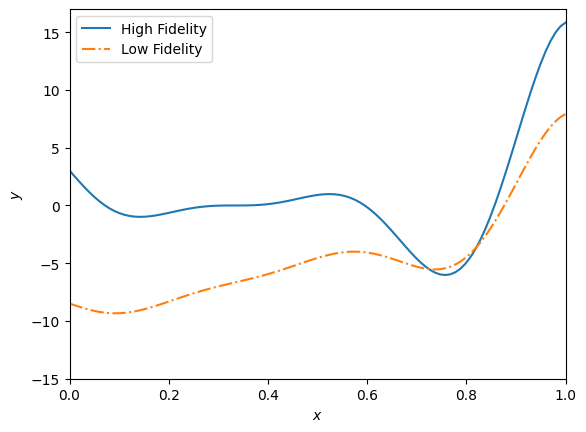

In [6]:
# Ploting High and low fidelity functions
plt.figure()
plt.plot(x, HF, label ='High Fidelity')
plt.plot(x, LF, linestyle = '-.' , label ='Low Fidelity')
plt.legend(loc=0)
plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

#### Sampling
The idea here is the same as the MFK example, we want to cover as much space as possible with low-fidelity data and use enough high fidelity samples to learn the relationship between fidelity levels.

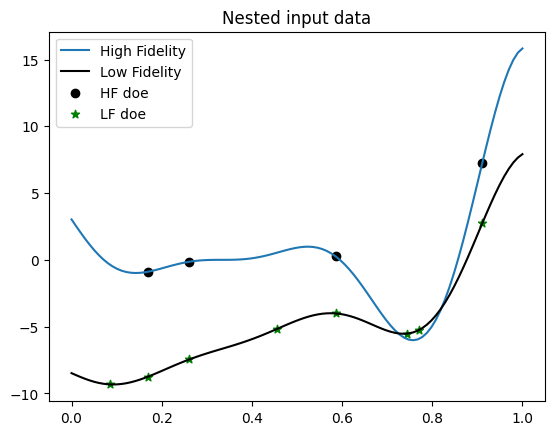

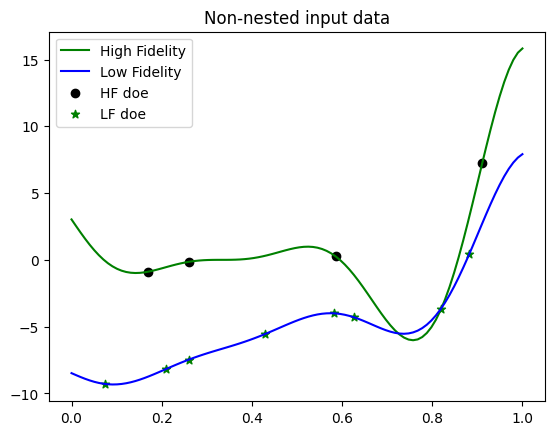

In [7]:
# LHS sampling with 2 levels of fidelity
ndim = 1 #1 dimension example
nlvl = 2 # 2 levels
ndoe_HF = 4 #4 high fidelity points

#Nested DOE
xlimits = np.array([[0.0, 1.0]])
xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits, random_state=51)

# seeds 2, 9, 12, 51
xt_c, xt_e = xdoes(ndoe_HF)
ndoe_LF = np.shape(xt_c)[0]
yt_e = Forrester_HF(xt_e)
yt_c = Forrester_LF(xt_c)
#Creation of non-nested input data, displacing the LF points randomly using a delta

#xlimits = np.array([[0.0, 4.0], [0.0, 3.0]])
sampling = LHS(xlimits=xlimits,criterion='ese')

x0_LF = sampling(ndoe_LF)
x0_HF = xt_e
y0_LF = Forrester_LF(x0_LF)
y0_HF = Forrester_HF(x0_HF)

plt.figure()
plt.title("Nested input data")
plt.plot(x, HF, label ='High Fidelity')
plt.plot(x, LF , c ='k', label ='Low Fidelity')
plt.scatter(xt_e, yt_e, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(xt_c, yt_c, marker = '*' , color ='g', label ='LF doe')
plt.legend()

plt.figure()
plt.title("Non-nested input data")
plt.plot(x, HF,c='g', label ='High Fidelity')
plt.plot(x, LF , c ='b', label ='Low Fidelity')
plt.scatter(x0_HF, y0_HF, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(x0_LF, y0_LF, marker = '*' , color ='g', label ='LF doe')
plt.legend()

# 2. Training the model for 2 levels 1D

## 2.1-Training for the nested input data

In [8]:
#Initial parameters for the models
theta0 = [1.]
theta_bounds = [1e-2, 13.]

#MFCK model
mfck = MFCK(theta0 = theta0, theta_bounds = theta_bounds, hyper_opt = opti, n_start = n_start)
mfck.set_training_values(xt_c, yt_c, name=0)
mfck.set_training_values(xt_e, yt_e)
mfck.train()

medianmf0,varmf0,medianmf1,varmf1 = mfck.predict(x)
varmf0=np.diag(varmf0).reshape(-1,1)
varmf1=np.diag(varmf1).reshape(-1,1)

#MFK model
sm = MFK(hyper_opt=opti,theta0= theta0, theta_bounds = theta_bounds,propagate_uncertainty=True, n_start=n_start)
sm.set_training_values(xt_c, yt_c, name=0)
sm.set_training_values(xt_e, yt_e)
sm.train()

#HF
mean_nmf_hfn = sm.predict_values(x)
va_nmf_hfn = sm.predict_variances(x)
# LF
mean_nmf_lfn = sm._predict_intermediate_values(x, 1)
va_nmf_lfn, _ =  sm.predict_variances_all_levels(x)
va_nmf_lfn = va_nmf_lfn[:,0].reshape(-1,1)


___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.7763369
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0006397
   
   Prediction time/pt. (sec) :  0.0000064
   


In [9]:
print('Optimal hyperparameters for MFK', sm.optimal_theta) #here with 2 levels we have 2 hyperparameters

Optimal hyperparameters for MFK [array([1.08935682]), array([0.01])]


In [10]:
print('Optimal hyperparameters for MFCK', mfck.theta) #here with 2 levels we have 5 hyperparameters

Optimal hyperparameters for MFCK [ 62.01430822  12.67427151 100.           0.39904953   1.77275919]


As explained at the begining we have the following auto-regressive formulation
$$
    Y_{k} = \rho_{k}\;Y_{k-1} + \gamma_k\\ k>0
$$

In this case we have the lowest fidelity $Y_{0}\sim\mathcal{GP}(0,K(\cdot,\cdot))$, $\rho_{k}$ being a scale factor and $\gamma_k\sim\mathcal{GP}({0,K(\cdot,\cdot)})$ to measure the discrepancies between $Y_{k}$ and $Y_{k-1}$. After, we model the higher fidelity levels using the auto-regressive formulation.

We define $K(\cdot,\cdot)$ as some kernel function for covariance calculation

This kernel function has Hyper-parameters (HP) $\Theta=\{\sigma^2,\theta\}$

In this context if we want to run MFCK for 2 fidelity levels we have the set of HP of the level $Y_{0}$ and the set of HP given by the next level $Y_{k}$,

$$
\Theta=\{\sigma^2_0,\theta_0,\sigma^2_{\gamma_{1}},\theta_{\gamma_{1}},\rho_1 \}
$$

being $\sigma^2_0,\theta_0$ the HP for the kernel for the level $0$ and $\sigma^2_\gamma,\theta_\gamma,\rho$ the HP for the estimation of the next level using the auto-regressive formulation.

Each set of HP $\sigma^2_{\gamma_{k}},\theta_{\gamma_{k}},\rho_k$ must be added per level of fidelity. For example, for three fidelity levels the set of HP is : $\Theta=\{\sigma^2_0,\theta_0,\sigma^2_{\gamma_{1}},\theta_{\gamma_{1}},\rho_1, \sigma^2_{\gamma_{2}},\theta_{\gamma_{2}},\rho_2 \}$



<p class="alert alert-warning" style="padding:1em">

**MFCK is adapted for isotropic kernels. MFK uses anisotropic kernels.** In the case of MFCK, independently of the dimension of the input data, the amount of hyper-parameters to optimize will be the same.

 </p>

## 2.2-Training for non-nested input data

In [11]:
#Using MFK
sm1 =  MFK(theta0= theta0, theta_bounds = theta_bounds, propagate_uncertainty=True, n_start=n_start)
sm1.set_training_values(x0_LF, y0_LF, name=0)
sm1.set_training_values(x0_HF, y0_HF)
sm1.train()

mean_nmf_hf = sm1.predict_values(x)
va_nmf_hf = sm1.predict_variances(x)

mean_nmf_lf = sm1._predict_intermediate_values(x, 1)
var0, _ =  sm1.predict_variances_all_levels(x)
var0 = var0[:,0].reshape(-1,1)

#Using MFCK
mfck1 = MFCK(hyper_opt=opti,n_start=n_start)
mfck1.set_training_values(x0_LF, y0_LF, name=0)
mfck1.set_training_values(x0_HF, y0_HF)
mfck1.train()
a,m,a1,m1 = mfck1.predict(x)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.9050210
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0007489
   
   Prediction time/pt. (sec) :  0.0000075
   


# 3-Plotting results for 2 levels 1D

Text(0.5, 1.0, 'MFCK, non-nested input data')

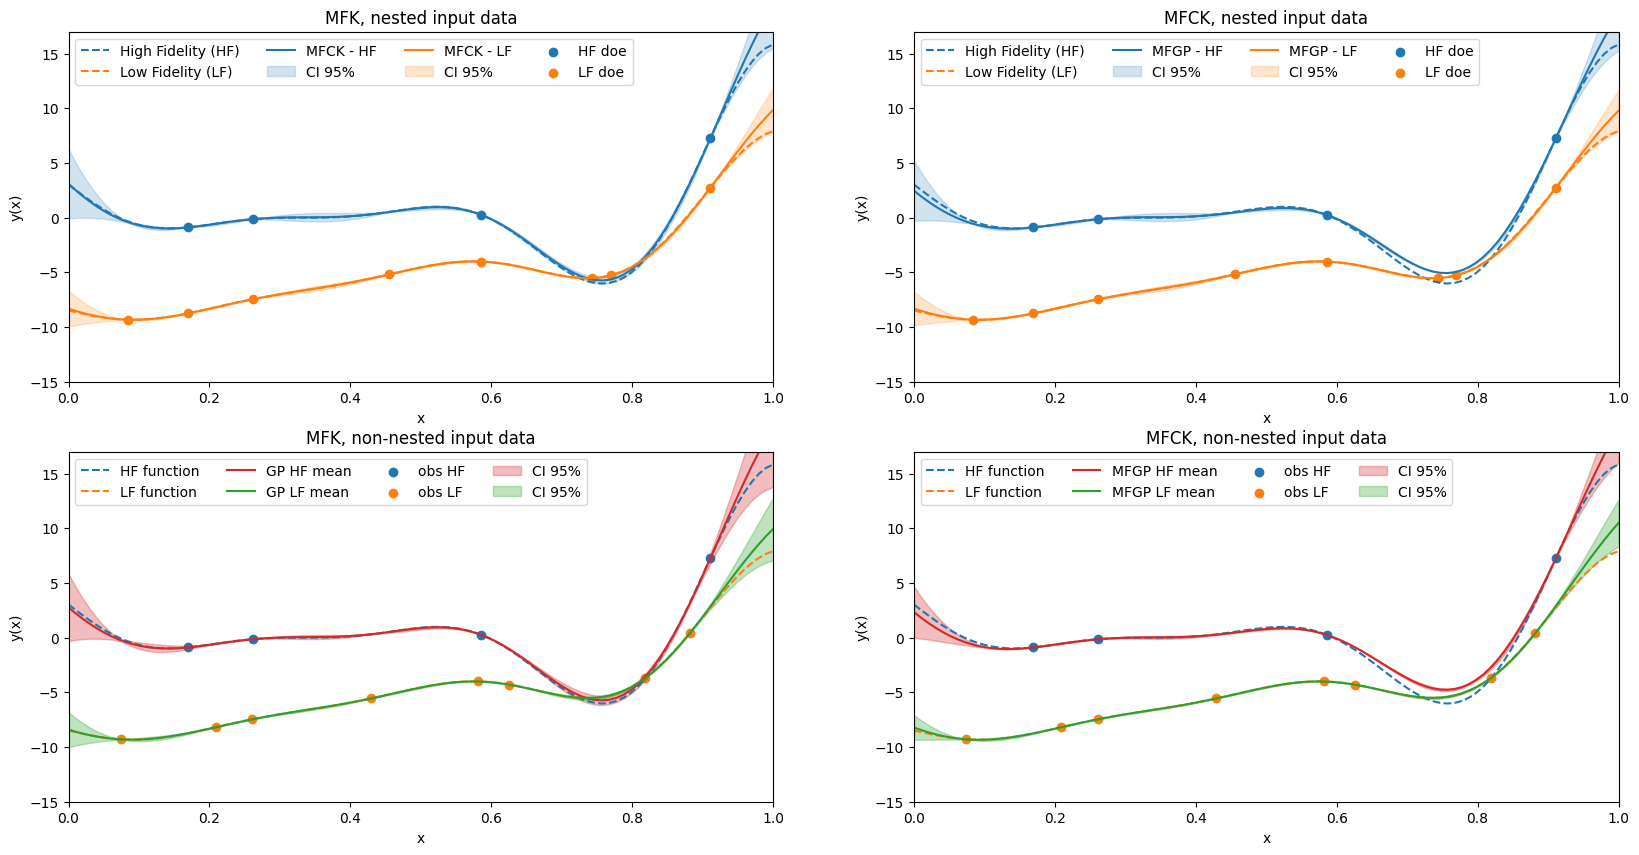

In [12]:
plt.figure(figsize = (20, 10))

plt.subplot(2,2,1)
plt.plot(x, HF, '--C0', label='High Fidelity (HF)')
plt.plot(x, LF, '--C1', label='Low Fidelity (LF)')
plt.plot(x, mean_nmf_hfn, 'C0', label='MFCK - HF')
plt.fill_between(np.ravel(x), np.ravel(mean_nmf_hfn-1.96*np.sqrt(va_nmf_hfn)),
                    np.ravel(mean_nmf_hfn+1.96*np.sqrt(va_nmf_hfn)),
                    color='C0',alpha=0.2, label ='CI 95%')
plt.plot(x, mean_nmf_lfn, 'C1', label='MFCK - LF')
plt.fill_between(np.ravel(x), np.ravel(mean_nmf_lfn-1.96*np.sqrt(va_nmf_lfn)),
                    np.ravel(mean_nmf_lfn+1.96*np.sqrt(va_nmf_lfn)),
                    color='C1',alpha=0.2, label ='CI 95%')


plt.scatter(xt_e, yt_e, color='C0', label='HF doe')
plt.scatter(xt_c, yt_c, color='C1', label='LF doe')

plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend(loc=2, ncol=4)
plt.title('MFK, nested input data')

plt.subplot(2,2,2)
plt.plot(x, HF, '--C0', label='High Fidelity (HF)')
plt.plot(x, LF, '--C1', label='Low Fidelity (LF)')
plt.plot(x, medianmf0, 'C0', label='MFGP - HF')

plt.fill_between(np.ravel(x), np.ravel(medianmf0-1.96*np.sqrt(varmf0)),
                    np.ravel(medianmf0+1.96*np.sqrt(varmf0)),
                    color='C0',alpha=0.2, label ='CI 95%')
plt.plot(x, medianmf1, 'C1', label='MFGP - LF')
plt.fill_between(np.ravel(x), np.ravel(medianmf1-1.96*np.sqrt(varmf1)),
                    np.ravel(medianmf1+1.96*np.sqrt(varmf1)),
                    color='C1',alpha=0.2, label ='CI 95%')


plt.scatter(xt_e, yt_e, color='C0', label='HF doe')
plt.scatter(xt_c, yt_c, color='C1', label='LF doe')
plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend(loc=2, ncol=4)
plt.title('MFCK, nested input data')
plt.subplot(2,2,3)
# plot LF and HF target functions
plt.plot(x, HF, "C0--",label="HF function")
plt.plot(x, LF, "C1--",label="LF function")
plt.plot(x, mean_nmf_hf, "C3",label="GP HF mean")
plt.plot(x, mean_nmf_lf, "C2",label="GP LF mean")
plt.scatter(x0_HF, y0_HF,  color = 'C0', label = "obs HF")
plt.scatter(x0_LF, y0_LF,  color = 'C1', label = "obs LF")
upperBound = mean_nmf_hf.flatten() + 1.96*np.sqrt(np.abs((va_nmf_hf.flatten())))
lowerBound = mean_nmf_hf.flatten() - 1.96*np.sqrt(np.abs((va_nmf_hf.flatten())))
upperBound1 = mean_nmf_lf.flatten() + 1.96*np.sqrt(np.abs((var0.flatten())))
lowerBound1 = mean_nmf_lf.flatten() - 1.96*np.sqrt(np.abs((var0.flatten())))
plt.fill_between(x.flatten(), lowerBound.flatten(), upperBound.flatten(),
    label="CI 95%",
    color="C3", alpha=0.3)
plt.fill_between(x.flatten(), lowerBound1.flatten(), upperBound1.flatten(),
    label="CI 95%",
    color="C2", alpha=0.3)
plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend(loc=2, ncol=4)
plt.title('MFK, non-nested input data')
plt.subplot(2,2,4)
plt.plot(x, HF, "C0--",label="HF function")
plt.plot(x, LF, "C1--",label="LF function")
plt.plot(x, a, "C3",label="MFGP HF mean")
plt.plot(x, a1, "C2",label="MFGP LF mean")
plt.scatter(x0_HF, y0_HF, color = 'C0', label = "obs HF")
plt.scatter(x0_LF, y0_LF, color = 'C1', label = "obs LF")
upperBound2 = a.flatten() + 1.96*np.sqrt(np.diag(m))
lowerBound2 = a.flatten() - 1.96*np.sqrt(np.diag(m))
upperBound3 = a1.flatten() + 1.96*np.sqrt(np.diag(m1))
lowerBound3 = a1.flatten() - 1.96*np.sqrt(np.diag(m1))
plt.fill_between(x.flatten(), lowerBound2.flatten(), upperBound2.flatten(),
    label="CI 95%",
    color="C3", alpha=0.3)
plt.fill_between(x.flatten(), lowerBound3.flatten(), upperBound3.flatten(),
    label="CI 95%",
    color="C2", alpha=0.3)
plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend(loc=2, ncol=4)
plt.title('MFCK, non-nested input data')

## 4-RMSE comparison between MFK and MFCK for 2 levels, 1D

In [13]:
# Add RMSE

#MFCK: RMSE HF non-nested
rmseHF = np.sqrt(np.mean((HF.flatten() - a.flatten())**2))
#RMSE Low Fidelity non-nested
rmseLF = np.sqrt(np.mean((LF.flatten() - a1.flatten())**2))

#MFK: RMSE HF non-nested
rmseHF1 = np.sqrt(np.mean((HF.flatten() - mean_nmf_hf.flatten())**2))
#RMSE LF non-nested
rmseLF1 = np.sqrt(np.mean((LF.flatten() - mean_nmf_lf.flatten())**2))


#MFCK: RMSE HF nested
rmseHF2 = np.sqrt(np.mean((HF.flatten() - medianmf0.flatten())**2))
#      RMSE LF nested
rmseLF2 = np.sqrt(np.mean((LF.flatten() - medianmf1.flatten())**2))

#MFK: RMSE LF nested
rmseHF3 = np.sqrt(np.mean((HF.flatten() - mean_nmf_hfn.flatten())**2))
#      RMSE LF nested
rmseLF3 = np.sqrt(np.mean((LF.flatten() - mean_nmf_lfn.flatten())**2))

print('RMSE for nested')
print('           HF                     LF')
print('MFK  :',rmseHF3,rmseLF3)
print('MFCK :',rmseHF2,rmseLF2)


print('\n')

print('RMSE for non-nested ')
print('           HF                     LF')
print('MFK  :',rmseHF1,rmseLF1)
print('MFCK :',rmseHF,rmseLF)


RMSE for nested
           HF                     LF
MFK  : 0.5514696706250992 0.2974998719721408
MFCK : 0.5552059664138522 0.2852195081354992


RMSE for non-nested 
           HF                     LF
MFK  : 0.5293748076587738 0.3214255963629995
MFCK : 0.6862201347941749 0.41746235251976777


# 5-Experiment for 3 levels 1D

In this example, we compare the same models by adding another level of fidelity using the Forrester functions (HF, MF et LF defined in the beginning).

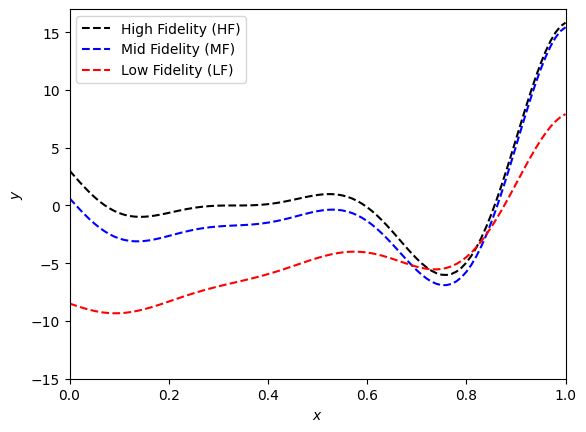

In [14]:
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
plt.figure()
plt.plot(x, Forrester_HF(x), "--k", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--b", label="Mid Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--r", label="Low Fidelity (LF)")
plt.legend(loc=0)
plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

Sampling for 3 levels

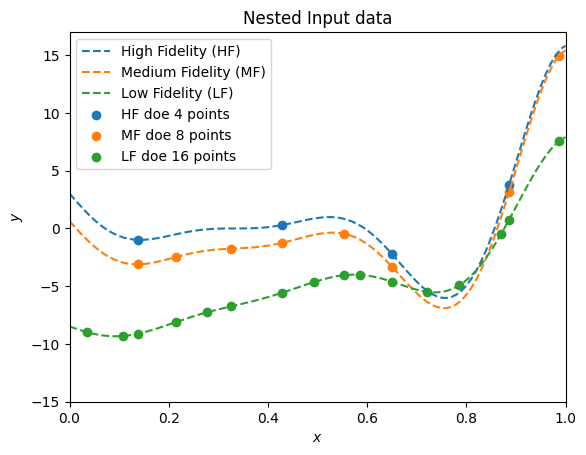

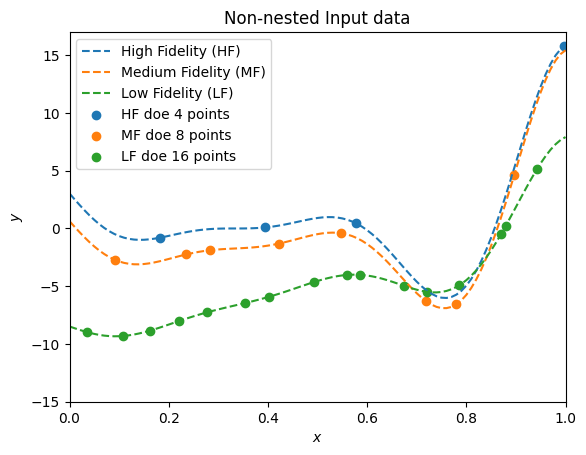

In [15]:
# LHS sampling with nested DOE: 3 levels, 1 dimension, 3 HF points
ndim = 1
nlvl = 3
ndoe_hf = 4
random_state= 0

xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits, random_state=random_state)
Xt_c, Xt_m, Xt_e = xdoes(ndoe_hf)

Xt_e=np.sort(Xt_e,axis=0)
Xt_m=np.sort(Xt_m,axis=0)
Xt_c=np.sort(Xt_c,axis=0)

ndoe_lf = np.shape(Xt_c)[0]
ndoe_mf = np.shape(Xt_m)[0]

# Expensive DOE with 3 points = Xt_e
# Intermediate DOE with 6 points = Xt_m
# Cheap DOE with 12 points Xt_c


# Evaluate the HF, MF and LF functions
yt_e = Forrester_HF(Xt_e)
yt_m = Forrester_MF(Xt_m)
yt_c = Forrester_LF(Xt_c)


#Now for non-nested input data
sampling = LHS(xlimits=xlimits,criterion='ese',random_state=random_state)

x0_LF = sampling(ndoe_lf)
x0_MF = sampling(ndoe_mf)
x0_HF = sampling(ndoe_hf)


y0_LF = Forrester_LF(x0_LF)
y0_MF = Forrester_MF(x0_MF)
y0_HF = Forrester_HF(x0_HF)


plt.figure()
plt.title('Nested Input data')
plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")
plt.scatter(
    Xt_e, yt_e, marker="o", color="C0", label="HF doe " + str(ndoe_hf) + " points"
)
plt.scatter(
    Xt_m, yt_m, marker="o", color="C1", label="MF doe " + str(ndoe_mf) + " points"
)
plt.scatter(
    Xt_c, yt_c, marker="o", color="C2", label="LF doe " + str(ndoe_lf) + " points"
)
plt.legend(loc=0)
plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

plt.figure()
plt.title('Non-nested Input data')
plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")
plt.scatter(
    x0_HF, y0_HF, marker="o", color="C0", label="HF doe " + str(ndoe_hf) + " points"
)
plt.scatter(
    x0_MF, y0_MF, marker="o", color="C1", label="MF doe " + str(ndoe_mf) + " points"
)
plt.scatter(
    x0_LF, y0_LF, marker="o", color="C2", label="LF doe " + str(ndoe_lf) + " points"
)
plt.legend(loc=0)
plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

### 5.1-Training for nested input data (3 levels)

In [16]:
#Build the MFCK model with 3 levels
mfck_3lvl_1d = MFCK(theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt=opti,n_start=n_start)
# low-fidelity dataset names being integers from 0 to level-1
mfck_3lvl_1d.set_training_values(Xt_c, yt_c, name=0)
mfck_3lvl_1d.set_training_values(Xt_m, yt_m, name=1)
# high-fidelity dataset without name
mfck_3lvl_1d.set_training_values(Xt_e, yt_e)
# train the model
mfck_3lvl_1d.train()

#test for mfck
mean1,variance1,mean2,variance2,mean3,variance3 = mfck_3lvl_1d.predict(x)
variance1=np.diag(variance1).reshape(-1,1)
variance2=np.diag(variance2).reshape(-1,1)
variance3=np.diag(variance3).reshape(-1,1)

# Build the MFK object with 3 levels
sm = MFK(theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt=opti)
# low-fidelity dataset names being integers from 0 to level-1
sm.set_training_values(Xt_c, yt_c, name=0)
sm.set_training_values(Xt_m, yt_m, name=1)
# high-fidelity dataset without name
sm.set_training_values(Xt_e, yt_e)
# train the model
sm.train()

# test for MFK
nlvl = len(sm.X)
# query the outputs
y = sm.predict_values(x)
y0 = sm._predict_intermediate_values(x, 1)
y1 = sm._predict_intermediate_values(x, 2)
var = sm.predict_variances(x)
varAll, _ = sm.predict_variances_all_levels(x)
var0 = varAll[:, 0].reshape(-1, 1)
var1 = varAll[:, 1].reshape(-1, 1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.2316239
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009308
   
   Prediction time/pt. (sec) :  0.0000092
   


### 5.2 Training for non-nested input data (3 levels)

In [17]:
#Build the MFCK model with 3 levels
mfck_3lvl_1dn = MFCK(theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt=opti,n_start=n_start)
# low-fidelity dataset names being integers from 0 to level-1
mfck_3lvl_1dn.set_training_values(x0_LF, y0_LF, name=0)
mfck_3lvl_1dn.set_training_values(x0_MF, y0_MF, name=1)
# high-fidelity dataset without name
mfck_3lvl_1dn.set_training_values(x0_HF, y0_HF)
# train the model
mfck_3lvl_1dn.train()

#test for mfck
mean1n,variance1n,mean2n,variance2n,mean3n,variance3n = mfck_3lvl_1dn.predict(x)
variance1n=np.diag(variance1n).reshape(-1,1)
variance2n=np.diag(variance2n).reshape(-1,1)
variance3n=np.diag(variance3n).reshape(-1,1)

# Build the MFK object with 3 levels
smn = MFK(theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt=opti)
# low-fidelity dataset names being integers from 0 to level-1
smn.set_training_values(x0_LF, y0_LF, name=0)
smn.set_training_values(x0_MF, y0_MF, name=1)
# high-fidelity dataset without name
smn.set_training_values(x0_HF, y0_HF)
# train the model
smn.train()

# test for MFK
nlvl = len(sm.X)
# query the outputs
yn = smn.predict_values(x)
y0n = smn._predict_intermediate_values(x, 1)
y1n = smn._predict_intermediate_values(x, 2)
varn = smn.predict_variances(x)
varAlln, _ = smn.predict_variances_all_levels(x)
var0n = varAlln[:, 0].reshape(-1, 1)
var1n = varAlln[:, 1].reshape(-1, 1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.2503984
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0008767
   
   Prediction time/pt. (sec) :  0.0000087
   


### Comparison of optimal parameters for nested and non-nested input data in MFK and MFCK

In [18]:
print("Hyper-params MFK")
print("Nested",sm.optimal_theta)
print("Non-nested",smn.optimal_theta)
print("Hyper-params MFCK")
print("Nested:",mfck_3lvl_1d.theta)
print("Non-nested",mfck_3lvl_1dn.theta)

Hyper-params MFK
Nested [array([0.73241144]), array([1.52151473e-05]), array([1.e-06])]
Non-nested [array([0.69895193]), array([1.05203728e-05]), array([1.e-06])]
Hyper-params MFCK
Nested: [57.01068902 13.89339668 54.94490005  2.22993285  2.00091822 69.36502276
  1.22745691  0.986208  ]
Non-nested [53.22370637 14.44268281 82.01520565  3.08177029  1.97742368 45.8616843
  0.13258413  0.92254104]


### 5.3-Plotting the results

Text(0.5, 1.0, 'MFCK, non-nested input data')

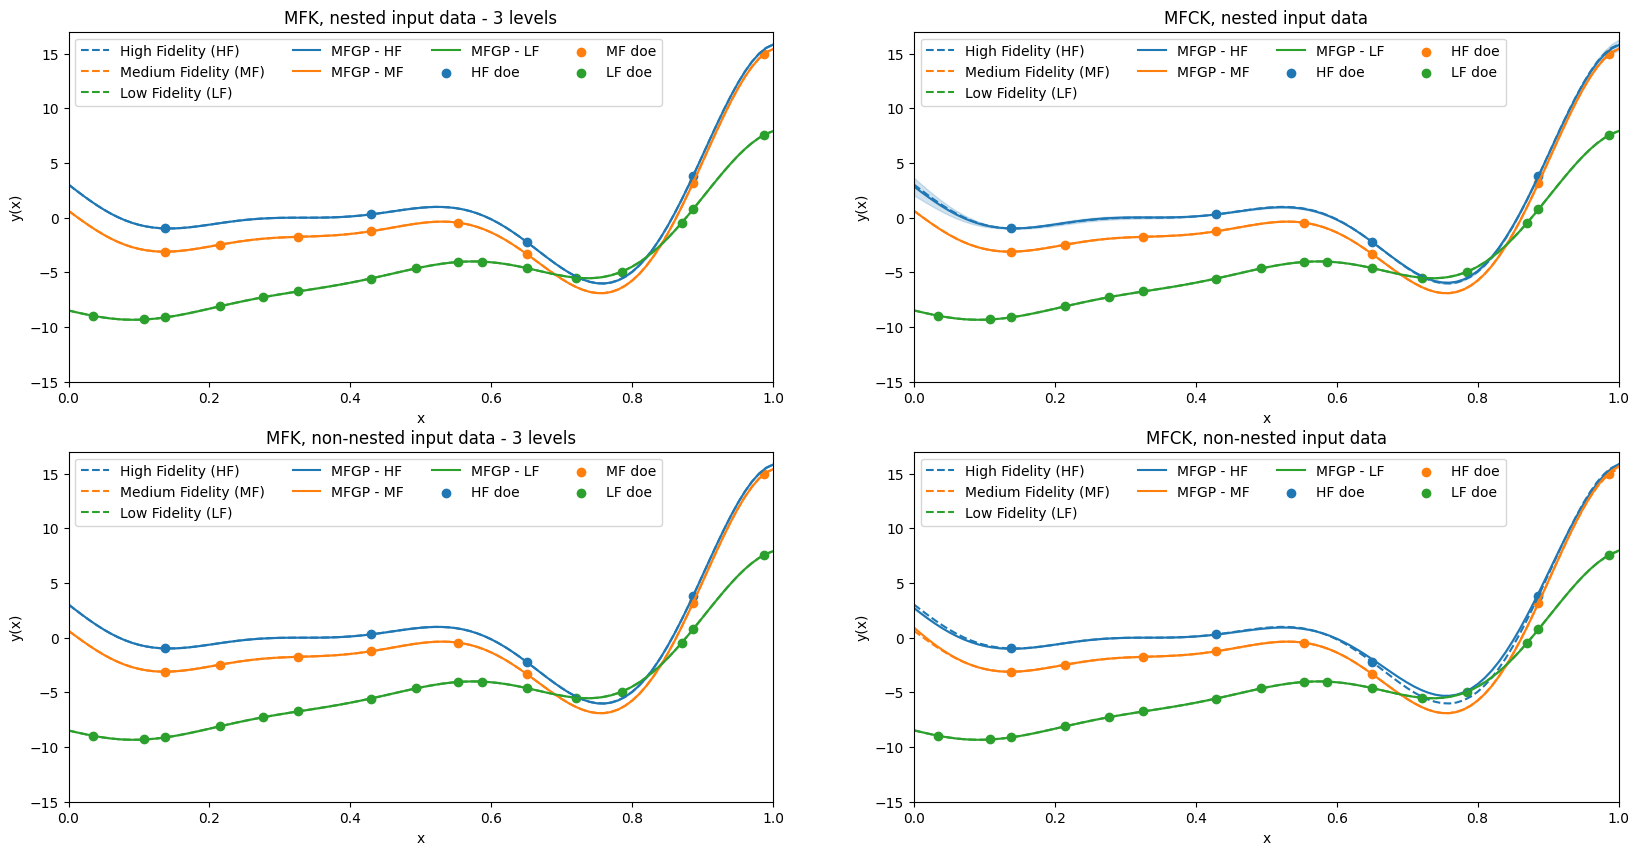

In [19]:
plt.figure(figsize = (20, 10))

plt.subplot(2,2,1)
plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")

plt.plot(x, y, "C0", label="MFGP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y - 3 * np.sqrt(var)),
    np.ravel(y + 3 * np.sqrt(var)),
    color="C0",
    alpha=0.2,
)
plt.plot(x, y1, "C1", label="MFGP - MF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y1 - 3 * np.sqrt(var1)),
    np.ravel(y1 + 3 * np.sqrt(var1)),
    color="C1",
    alpha=0.2,
)
plt.plot(x, y0, "C2", label="MFGP - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y0 - 3 * np.sqrt(var0)),
    np.ravel(y0 + 3 * np.sqrt(var0)),
    color="C2",
    alpha=0.2,
)

plt.scatter(Xt_e, yt_e, color='C0', label='HF doe')
plt.scatter(Xt_m, yt_m, color='C1', label='MF doe')
plt.scatter(Xt_c, yt_c, color='C2', label='LF doe')

plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend(loc=2, ncol=4)
plt.title('MFK, nested input data - 3 levels')


plt.subplot(2,2,2)

plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")

plt.plot(x, mean3, "C0", label="MFGP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean3 - 3 * np.sqrt(variance3)),
    np.ravel(mean3 + 3 * np.sqrt(variance3)),
    color="C0",
    alpha=0.2,
)
plt.plot(x, mean2, "C1", label="MFGP - MF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean2 - 3 * np.sqrt(variance2)),
    np.ravel(mean2 + 3 * np.sqrt(variance2)),
    color="C1",
    alpha=0.2,
)
plt.plot(x, mean1, "C2", label="MFGP - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean1 - 3 * np.sqrt(variance1)),
    np.ravel(mean1 + 3 * np.sqrt(variance1)),
    color="C2",
    alpha=0.2,
)

plt.scatter(Xt_e, yt_e, color='C0', label='HF doe')
plt.scatter(Xt_m, yt_m, color='C1', label='HF doe')
plt.scatter(Xt_c, yt_c, color='C2', label='LF doe')
plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend(loc=2, ncol=4)
plt.title('MFCK, nested input data')


plt.subplot(2,2,3)
plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")

plt.plot(x, yn, "C0", label="MFGP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(yn - 3 * np.sqrt(varn)),
    np.ravel(yn + 3 * np.sqrt(varn)),
    color="C0",
    alpha=0.2,
)
plt.plot(x, y1n, "C1", label="MFGP - MF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y1n - 3 * np.sqrt(var1n)),
    np.ravel(y1n + 3 * np.sqrt(var1n)),
    color="C1",
    alpha=0.2,
)
plt.plot(x, y0n, "C2", label="MFGP - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(y0n - 3 * np.sqrt(var0n)),
    np.ravel(y0n + 3 * np.sqrt(var0n)),
    color="C2",
    alpha=0.2,
)

plt.scatter(Xt_e, yt_e, color='C0', label='HF doe')
plt.scatter(Xt_m, yt_m, color='C1', label='MF doe')
plt.scatter(Xt_c, yt_c, color='C2', label='LF doe')

plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend(loc=2, ncol=4)
plt.title('MFK, non-nested input data - 3 levels')

plt.subplot(2,2,4)
plt.plot(x, Forrester_HF(x), "--C0", label="High Fidelity (HF)")
plt.plot(x, Forrester_MF(x), "--C1", label="Medium Fidelity (MF)")
plt.plot(x, Forrester_LF(x), "--C2", label="Low Fidelity (LF)")

plt.plot(x, mean3n, "C0", label="MFGP - HF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean3n - 3 * np.sqrt(variance3n)),
    np.ravel(mean3n + 3 * np.sqrt(variance3n)),
    color="C0",
    alpha=0.2,
)
plt.plot(x, mean2n, "C1", label="MFGP - MF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean2n - 3 * np.sqrt(variance2n)),
    np.ravel(mean2n + 3 * np.sqrt(variance2n)),
    color="C1",
    alpha=0.2,
)
plt.plot(x, mean1n, "C2", label="MFGP - LF")
plt.fill_between(
    np.ravel(x),
    np.ravel(mean1n - 3 * np.sqrt(variance1n)),
    np.ravel(mean1n + 3 * np.sqrt(variance1n)),
    color="C2",
    alpha=0.2,
)

plt.scatter(Xt_e, yt_e, color='C0', label='HF doe')
plt.scatter(Xt_m, yt_m, color='C1', label='HF doe')
plt.scatter(Xt_c, yt_c, color='C2', label='LF doe')
plt.ylim(ylimits[0][0],ylimits[0][1])
plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend(loc=2, ncol=4)
plt.title('MFCK, non-nested input data')

## 6-RMSE comparison between MFK and MFCK for 3 levels, 1D

In [20]:
# Add RMSE
HF=Forrester_HF(x)
MF=Forrester_MF(x)
LF=Forrester_LF(x)


#MFCK: RMSE HF non-nested
rmseHF_3l = np.sqrt(np.mean((HF.flatten() - mean3n.flatten())**2))
#RMSE Medium Fidelity non-nested
rmseMF_3l = np.sqrt(np.mean((MF.flatten() - mean2n.flatten())**2))
#RMSE Low Fidelity non-nested
rmseLF_3l = np.sqrt(np.mean((LF.flatten() - mean1n.flatten())**2))

#MFK: RMSE HF non-nested
rmseHF1_3l = np.sqrt(np.mean((HF.flatten() - yn.flatten())**2))
#RMSE MF non-nested
rmseMF1_3l = np.sqrt(np.mean((MF.flatten() - y1n.flatten())**2))
#RMSE LF non-nested
rmseLF1_3l = np.sqrt(np.mean((LF.flatten() - y0n.flatten())**2))


#MFCK: RMSE HF nested
rmseHF2_3l = np.sqrt(np.mean((HF.flatten() - mean3.flatten())**2))
#RMSE Medium Fidelity nested
rmseMF2_3l = np.sqrt(np.mean((MF.flatten() - mean2.flatten())**2))
#      RMSE LF nested
rmseLF2_3l = np.sqrt(np.mean((LF.flatten() - mean1.flatten())**2))

#MFK: RMSE LF nested
rmseHF3_3l = np.sqrt(np.mean((HF.flatten() - y.flatten())**2))
#RMSE MF nested
rmseMF3_3l = np.sqrt(np.mean((MF.flatten() - y1.flatten())**2))
#      RMSE LF nested
rmseLF3_3l = np.sqrt(np.mean((LF.flatten() - y0.flatten())**2))

print('RMSE for nested-3 levels')
print('          HF                MF                 LF')
print('MFK  :',rmseHF3_3l,rmseMF3_3l,rmseLF3_3l)
print('MFCK :',rmseHF2_3l,rmseMF2_3l,rmseLF2_3l)


print('\n')

print('RMSE for non-nested-3 levels ')
print('          HF                MF                 LF')
print('MFK  :',rmseHF1_3l,rmseMF1_3l,rmseLF1_3l)
print('MFCK :',rmseHF_3l,rmseMF_3l,rmseLF_3l)

RMSE for nested-3 levels
          HF                MF                 LF
MFK  : 0.0005818833981027284 0.0005828724382192746 0.0002948005469056396
MFCK : 0.05261226401206377 0.00265060478560925 0.0016704008973391297


RMSE for non-nested-3 levels 
          HF                MF                 LF
MFK  : 0.0040966272418764 0.002308527367867607 0.0011524384033350895
MFCK : 0.2921437342299918 0.05160887100116857 0.006152918260853839


## 6. For 2D experimental data

In [21]:
from matplotlib import cm
def Rosen_HF(point):
    # Expensive Rosen function
    res = 100*(point[:,1] - point[:,0]**2)**2 + (1.0 - point[:,0])**2
    return res
def Rosen_MF(point):
    # Expensive Rosen function
    res = 100*(point[:,1] - point[:,0]**2)**2 + (2.0 - point[:,0])**2
    return res
def Rosen_LF(point):
    # Expensive Rosen function
    #res = 5*((1.0 - point[:,0])**2 + 100*(point[:,1] - point[:,0]**2)**2) + 0.1*np.sin(10*point[:,0] + 5*point[:,1])
    res = 50*(point[:,1] - point[:,0]**2)**2 + (-2 - point[:,0])**2 - (0.5*point[:,0])
    return res

Sampling for 2D

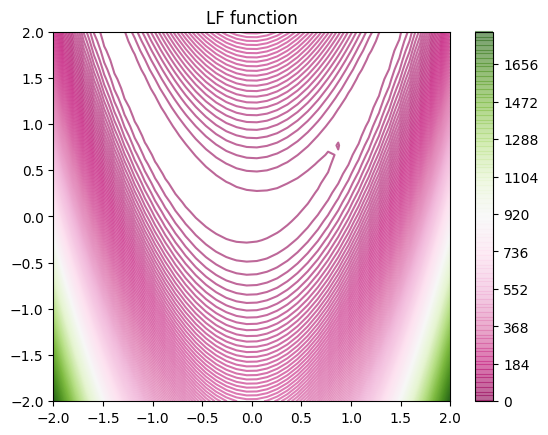

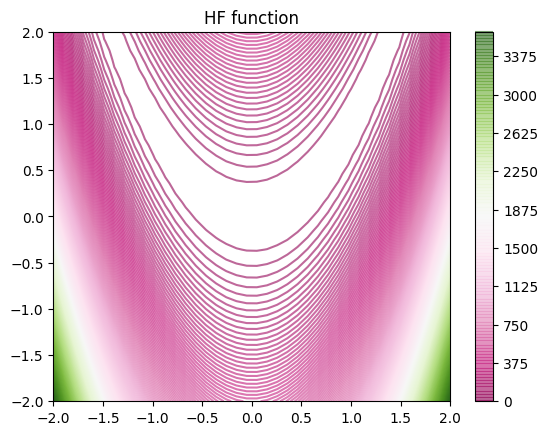

In [22]:
#HF observations
num = 5
x = np.linspace(-2., 2., num)
y = np.linspace(-2.,2., num)
xv, yv = np.meshgrid(x, y)
x_hf = np.array([np.ravel(xv), np.ravel(yv)]).T
z_HF = np.zeros([num*num, 1])
z_HF = Rosen_HF(x_hf)

num = 10
x = np.linspace(-2., 2., num)
y = np.linspace(-2.,2., num)
xv, yv = np.meshgrid(x, y)
x_mf = np.array([np.ravel(xv), np.ravel(yv)]).T
z_MF = np.zeros([num*num, 1])
z_MF = Rosen_MF(x_mf)

# LF observations
num = 20
x = np.linspace(-2., 2., num)
y = np.linspace(-2.,2., num)
xv, yv = np.meshgrid(x, y)

x_lf = np.array([np.ravel(xv), np.ravel(yv)]).T
z_LF = np.zeros([num*num, 1])
z_LF = Rosen_LF(x_lf)

#Test set
num = 40
x = np.linspace(-2., 2., num)
y = np.linspace(-2.,2., num)
xv, yv = np.meshgrid(x, y)
x_test = np.array([np.ravel(xv), np.ravel(yv)]).T

z_test_LF = np.zeros([num*num, 1])
z_test_LF = Rosen_LF(x_test).reshape(-1,1)

z_test_HF = np.zeros([num*num, 1])
z_test_HF = Rosen_HF(x_test).reshape(-1,1)



#Plots for High and Low fidelity Rosen functions.
fig1 = plt.figure()
axSurrogate1 = fig1.add_subplot(111)
axSurrogate1.set_title('LF function')
surf1 = axSurrogate1.contour(xv, yv, z_test_LF.reshape((num, num)),
                             300, cmap=cm.PiYG, antialiased=True, alpha=0.6)
fig1.colorbar(surf1)
fig1.show()


fig2 = plt.figure()
axSurrogate2 = fig2.add_subplot(111)
axSurrogate2.set_title('HF function')
surf2 = axSurrogate2.contour(xv, yv, z_test_HF.reshape((num, num)),
                             300, cmap=cm.PiYG, antialiased=True, alpha=0.6)
fig2.colorbar(surf2)
fig2.show()

### 6.1-Training for 2D/2 levels

In [28]:
# %% Build the MFK object with 2 levels
sm = MFK()
# low-fidelity dataset names being integers from 0 to level-1
sm.set_training_values(x_lf, z_LF, name=0)
# high-fidelity dataset without name
sm.set_training_values(x_hf, z_HF)
# train the model
sm.train()

mean_hf = sm.predict_values(x_test)
va_hf = sm.predict_variances(x_test)
mean_lf = sm._predict_intermediate_values(x_test, 1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 25
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 40.2685847
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1600
   
   Predicting ...
   Predicting - done. Time (sec):  0.0497470
   
   Prediction time/pt. (sec) :  0.0000311
   


In [30]:
print('Optimal hyperparameters for MFK', sm.optimal_theta) #here with 2 levels and 2 diemension so we have 4 hyperparameters (number dependant of the dimension as a anistopic kernel is used)

Optimal hyperparameters for MFK [array([0.55955918, 0.01630135]), array([5.08718469e-04, 1.00000000e-06])]


### 6.2 Training MFCK for 2D/2 levels

In [24]:
#Train MFCK
mfck1 = MFCK(theta0 =[1.],hyper_opt=opti)
mfck1.set_training_values(x_lf, z_LF, name=0)
mfck1.set_training_values(x_hf, z_HF)
mfck1.train()
means = []
covariances= []
means,covariances = mfck1.predict_multi_lvl(x_test)

In [25]:
print('Optimal hyperparameters for MFCK', mfck1.theta) #here with 2 levels we have 5 hyperparameters (number independant of the dimension as an istopic kernel is used)

Optimal hyperparameters for MFCK [100.           5.78596364 100.           0.70664035   1.99747167]


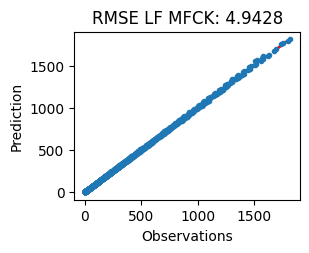

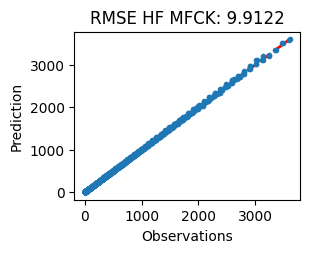

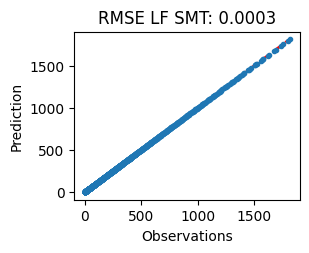

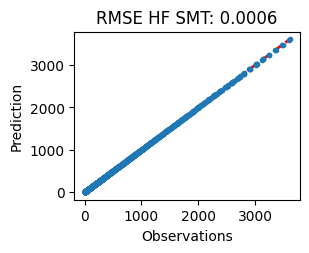

In [26]:
#%%Plot RMSE
#plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
rmse = np.sqrt(np.mean((z_test_LF.flatten() - means[0].flatten())**2))
# Plot results
start = np.min([means[0], z_test_LF])
end = np.max([means[0], z_test_LF])
#plt.figure(figsize=(8,8))
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_LF.flatten(), means[0].flatten(), '.')
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE LF MFCK: %.4f" %rmse)
plt.show()
plt.subplot(2,2,2)
rmse = np.sqrt(np.mean((z_test_HF.flatten() - means[1].flatten())**2))
# Plot results
start = np.min([means[1], z_test_HF])
end = np.max([means[1], z_test_HF])
#plt.figure(figsize=(8,8))
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_HF.flatten(), means[1].flatten(), '.')
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE HF MFCK: %.4f" %rmse)
plt.show()
plt.subplot(2,2,3)
rmse = np.sqrt(np.mean((z_test_LF.flatten() - mean_lf.flatten())**2))
# Plot results
start = np.min([mean_lf, z_test_LF])
end = np.max([mean_lf, z_test_LF])
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_LF.flatten(), mean_lf.flatten(), '.')
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE LF SMT: %.4f" %rmse)
plt.show()
plt.subplot(2,2,4)
rmse = np.sqrt(np.mean((z_test_HF.flatten() - mean_hf.flatten())**2))
# Plot results
start = np.min([mean_hf, z_test_HF])
end = np.max([mean_hf, z_test_HF])
#plt.figure(figsize=(8,8))
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_HF.flatten(), mean_hf.flatten(), '.')
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE HF SMT: %.4f" %rmse)
plt.show()

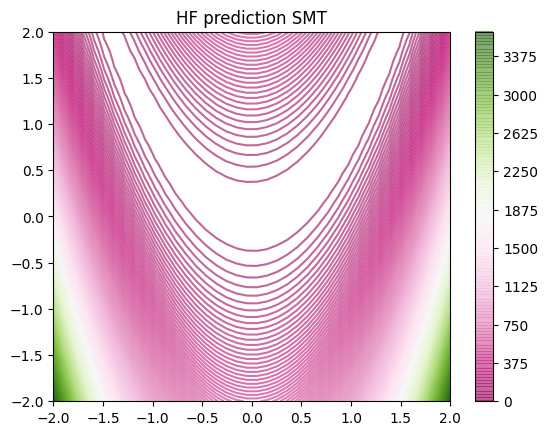

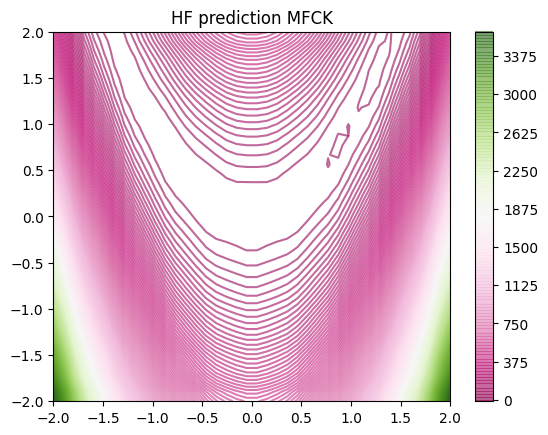

In [27]:
#To compare the prediction
fig4 = plt.figure()
axSurrogate4 = fig4.add_subplot(111)
axSurrogate4.set_title("HF prediction SMT")
surf4 = axSurrogate4.contour(
    xv, yv, mean_hf.reshape((num, num)), 300, cmap=cm.PiYG, antialiased=True, alpha=0.6
)
fig4.colorbar(surf4)
fig4.show()

fig3 = plt.figure()
axSurrogate3 = fig3.add_subplot(111)
axSurrogate3.set_title("HF prediction MFCK")
surf3 = axSurrogate3.contour(
    xv, yv, means[1].reshape((num, num)), 300, cmap=cm.PiYG, antialiased=True, alpha=0.6
)
fig3.colorbar(surf3)
fig3.show()

On this 2D example, we can see that the isotropic kernel has some limitations for MFCK. Considering an anitropic kernel will increase the number of hyperparameters (10 for 2D instead of 5 in 1D) but could improve the accuracy (as the one with MFK).